# Checks on SNR
Reference : [SDR - half-baked or well done? [Leroux 18]](https://arxiv.org/pdf/1811.02508.pdf) 

$SNR(x, \Delta) = 10 \log_{10}(\frac{\|x\|^2}{\|\Delta\|^2})$

$\Delta =  x - \hat{x}$ where 
- $x$ is the signal
- $\hat{x}$ is the prediction
- $\Delta$ is the prediction error

Numerical exemples:
- If $\sigma_{\Delta} = \sigma_{x}$ , 0db (same amount of noise as the signal)
- If $\sigma_{\Delta} = 2.\sigma_{x}$ , -6db (twice as much noise as the signal)
- If $\sigma_{\Delta} = \frac{\sigma_{x}}{2}$ , +6db (denoised by using 4 samples average for instance)

```
10*math.log10(2**2) 
>>> 6.020
```


In [1]:
from pathlib import Path
from gyraudio.audio_separation.visualization.pre_load_audio import audio_loading
from gyraudio.audio_separation.properties import (CLEAN,NOISY, MIXED, PATHS, BUFFERS)
from gyraudio.audio_separation.data.silence_detector import get_silence_mask
import torch
import matplotlib.pyplot as plt


In [2]:
idx = 11
sig_dict = audio_loading(
    Path(f"__data_source_separation/source_separation/test/{idx:04d}"),
    preload=True
)
snr_target = int(sig_dict[PATHS][MIXED].stem.split("snr_")[1])
print(snr_target)

-4


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
target = sig_dict[BUFFERS][CLEAN].to(device)
noise =  sig_dict[BUFFERS][NOISY].to(device)
mix = sig_dict["buffers"][MIXED].to(device)

In [4]:
silence_thresh = 0.0001
silence_mask = get_silence_mask(
        target,
        morph_kernel_size=499, k_smooth=21, thresh=0.0001
)

In [18]:
def get_snr(tgt, pred):
    prediction_noise = pred-tgt
    return  10.*torch.log10(torch.var(tgt) / torch.var(prediction_noise))
snr_input = get_snr(target, target+noise)
print(snr_input.item())

-7.207170009613037


In [19]:
target.squeeze(0).cpu().numpy().shape

(80000,)

In [29]:
20.*torch.log10(torch.std(target)/torch.std(noise))

tensor(-7.2072, device='cuda:0')

In [53]:
tgt_ma = torch.masked_select(target, (1-silence_mask).bool())
not_quiet_ratio   =(1-silence_mask).sum()/target.shape[-1]
print(f"Useful Signal proportion = {not_quiet_ratio:.2%}")
# tgt_ma = torch.masked_select(target, torch.ones_like(target).bool())
noisy_ma = torch.masked_select(noise, (1-silence_mask).bool())
20.*torch.log10(torch.std(noisy_ma)/torch.std(tgt_ma))
torch.std(tgt_ma), target.std()


Useful Signal proportion = 65.70%


(tensor(0.0076, device='cuda:0'), tensor(0.0062, device='cuda:0'))

In [59]:
power_ratio = 10**(float(snr_target)/10.)
print(f"SNR target = {snr_target} -> Expected power_ratio {power_ratio:.2f}")

SNR target = -4 -> Expected power_ratio 0.40


In [44]:
import math
noise_coefficient = math.sqrt(torch.var(tgt_ma)/torch.var(noise) /power_ratio) # The coeff!
noise_coefficient

0.8527958538909202

In [74]:
# noise_coefficient = 4.

In [75]:
# coeff_pred = ((mix-target)/noise)
# coeff_pred = torch.masked_select(coeff_pred, (1-silence_mask).bool())
# plt.plot(coeff_pred.squeeze(0).cpu().numpy())
# # plt.ylim(-10,10)

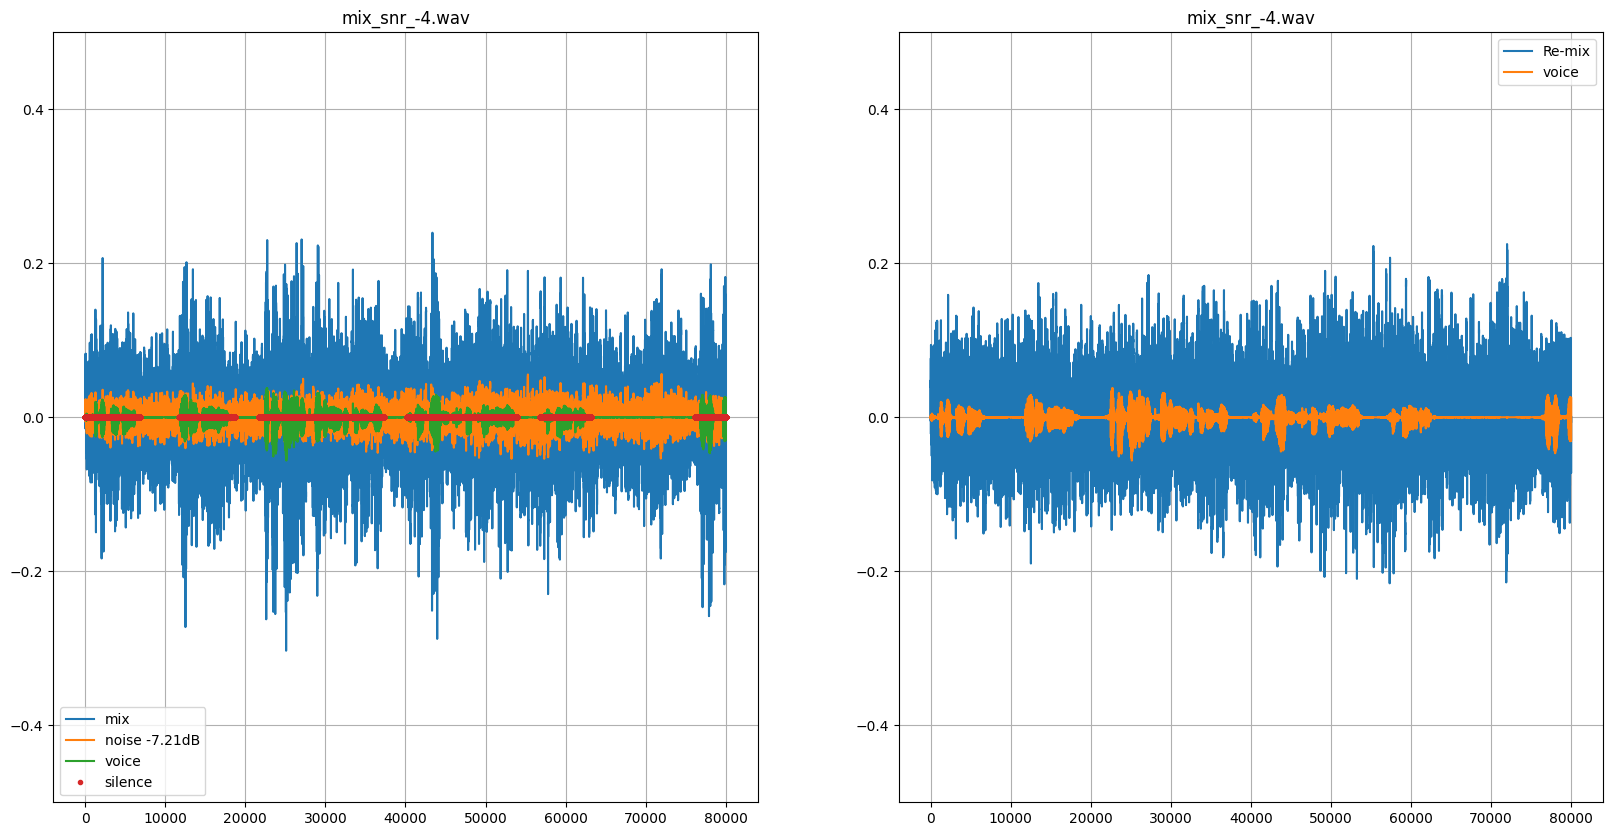

In [76]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(mix.squeeze(0).cpu().numpy(), label="mix")
plt.plot(noise.squeeze(0).cpu().numpy(), label=f"noise {snr_input:.2f}dB")
plt.plot(target.squeeze(0).cpu().numpy(), label="voice")
plt.plot(silence_mask.squeeze(0).cpu().numpy(), ".", label="silence")
plt.legend()
plt.title(sig_dict["paths"][MIXED].name)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.subplot(1, 2, 2)
new_mix = target + noise_coefficient*noise
plt.plot(new_mix.squeeze(0).cpu().numpy(), label="Re-mix")
# # plt.plot(noise_amplified, label=f"noise {snr_output:.2f}dB")
plt.plot(target.squeeze(0).cpu().numpy(), label="voice")
plt.legend()
plt.title(sig_dict["paths"][MIXED].name)
plt.ylim(-0.5, 0.5)
plt.grid()
plt.show()